**<font size="4">读取本地存放的PDF文件，将每页转换为图片格式，通过crop将每页图片的上部5%和底部8%切除，去掉页眉和页脚无效信息；将crop处理后的图片，以平行方式通过OCR算法处理为text，各页识别的text合并后写入output.txt文件</font>**

In [2]:
from PyPDF2 import PdfReader
from pdf2image import convert_from_bytes
from pdf2image.exceptions import PDFPageCountError
from PIL import Image
import pytesseract
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

import os

def process_page(page_num, pdf_bytes):
    try:
        # Convert a single PDF page to an image
        image = convert_from_bytes(pdf_bytes, first_page=page_num, last_page=page_num)[0]
    except PDFPageCountError:
        print(f"Unable to process page {page_num}. Skipping.")
        return None

    # Save the original image to the "original img" folder
    original_img_folder = "original img"
    os.makedirs(original_img_folder, exist_ok=True)
    image.save(f"{original_img_folder}/page_{page_num}.png")

    # Crop the image to exclude the top 5% and bottom 8% of the page area
    width, height = image.size
    top_crop = int(height * 0.05)
    bottom_crop = int(height * 0.92)
    cropped_image = image.crop((0, top_crop, width, bottom_crop))

    # Save the cropped image to the "cropped img" folder
    cropped_img_folder = "cropped img"
    os.makedirs(cropped_img_folder, exist_ok=True)
    cropped_image.save(f"{cropped_img_folder}/page_{page_num}.png")

    # Extract the text from the cropped image
    page_text = pytesseract.image_to_string(cropped_image).replace('\n', ' ')

    return page_text

from functools import partial


with open('COMPLAINT.pdf', 'rb') as pdf_file:
    # Read the PDF file as bytes
    pdf_bytes = pdf_file.read()

    # Read the PDF file
    pdf_reader = PdfReader(pdf_file)

    # Get the total number of pages
    num_pages = len(pdf_reader.pages)

    # Specify the starting page number (zero-based index)
    start_page_num = 9

    # Process the PDF pages in parallel and show a progress bar
    with ThreadPoolExecutor() as executor:
        process_page_with_pdf_bytes = partial(process_page, pdf_bytes=pdf_bytes)
        page_texts = list(tqdm(executor.map(process_page_with_pdf_bytes, range(start_page_num, num_pages)), total=num_pages-start_page_num, desc="Processing pages"))

# Filter out None values and concatenate the text from each page
text = ' '.join(filter(None, page_texts))

# Write the text to a plain text file with 'utf-8' encoding
with open('output.txt', 'w', encoding='utf-8') as f:
    f.write(text)



Processing pages: 100%|██████████████████████████████████████████████████████████████| 259/259 [04:36<00:00,  1.07s/it]


In [1]:
len(page_texts)

NameError: name 'page_texts' is not defined

In [3]:
page_texts[0]

'Plaintiff, by its undersigned attorneys, for its Complaint against Defendants, alleges as follows:  I. SHORT STATEMENT OF THE CASE  1. This case is based on a massive fraudulent scheme devised in 2012 primarily by Defendant China Construction America, Inc. (“CCA”) to enrich itself at the expense and to the harm of Plaintiff BML Properties, Ltd. (“BML Properties”). BML Properties was the 100 percent owner of the voting shares of the development entity Baha Mar Ltd., which was developing the multi-billion dollar Baha Mar resort complex in Nassau Bahamas (the “Project”) until 2015, when CCA’s scheme set in motion three years earlier led to the collapse of the Project and the loss of BML Properties’ enormous investment while CCA and its Chinese affiliates profited.  2. Defendants’ massive fraud is one of the largest construction-based frauds in this hemisphere. The scheme was based on CCA’s efforts to falsely create the appearance that it was working toward an on-time and on-budget openin

In [5]:
from transformers import GPT2Tokenizer

# Initialize the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

#### slipt the content in semantically meaningful manner, only cut off at sentance end. 


def split_into_chunks(text, max_tokens=1800):
    # Initialize the GPT-2 tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

    # Tokenize the content
    tokens = tokenizer.encode(text)

    # Split the tokens into chunks
    chunks = []
    current_chunk = []
    current_chunk_tokens = 0

    for token in tokens:
        # Get the decoded token to check for sentence-ending punctuation
        decoded_token = tokenizer.decode(token)

        # If adding the next token would exceed the token limit and the current chunk is not empty,
        # add the current chunk to the list of chunks and start a new chunk
        if current_chunk_tokens + 1 > max_tokens and decoded_token in (".", "!", "?"):
            chunks.append(current_chunk)
            current_chunk = []
            current_chunk_tokens = 0

        current_chunk.append(token)
        current_chunk_tokens += 1

    # Add the last chunk if it's not empty
    if current_chunk:
        chunks.append(current_chunk)

    # Convert the chunks of tokens back into text
    text_chunks = [tokenizer.decode(chunk) for chunk in chunks]

    return text_chunks


# Read the content of the text file
with open("COMPLAINT - plain text.txt", "r", encoding="utf-8") as f:
    content = f.read()

# Split the content into chunks
chunks = split_into_chunks(content)

# Print the number of chunks and the content of each chunk
print(f"Total chunks: {len(chunks)}")


Token indices sequence length is longer than the specified maximum sequence length for this model (103605 > 1024). Running this sequence through the model will result in indexing errors


Total chunks: 57


In [29]:
# Initialize variables for counting tokens and estimating cost
total_tokens = 0
total_cost = 0

# Tokenize each chunk and count the tokens
for chunk in chunks:
    tokens = tokenizer.encode(chunk)
    num_tokens = len(tokens)
    total_tokens += num_tokens

    # Calculate the cost of using the `text-embedding-ada-002` model
    # $0.0004 / 1K tokens for ada model
    cost_per_token = 0.0004 / 1000
    chunk_cost = num_tokens * cost_per_token
    total_cost += chunk_cost

print(f"Estimated number of tokens: {total_tokens}")
print(f"Estimated cost of using the `text-embedding-ada-002` model: ${total_cost:.2f}")


Token indices sequence length is longer than the specified maximum sequence length for this model (1874 > 1024). Running this sequence through the model will result in indexing errors


Estimated number of tokens: 103574
Estimated cost of using the `text-embedding-ada-002` model: $0.04


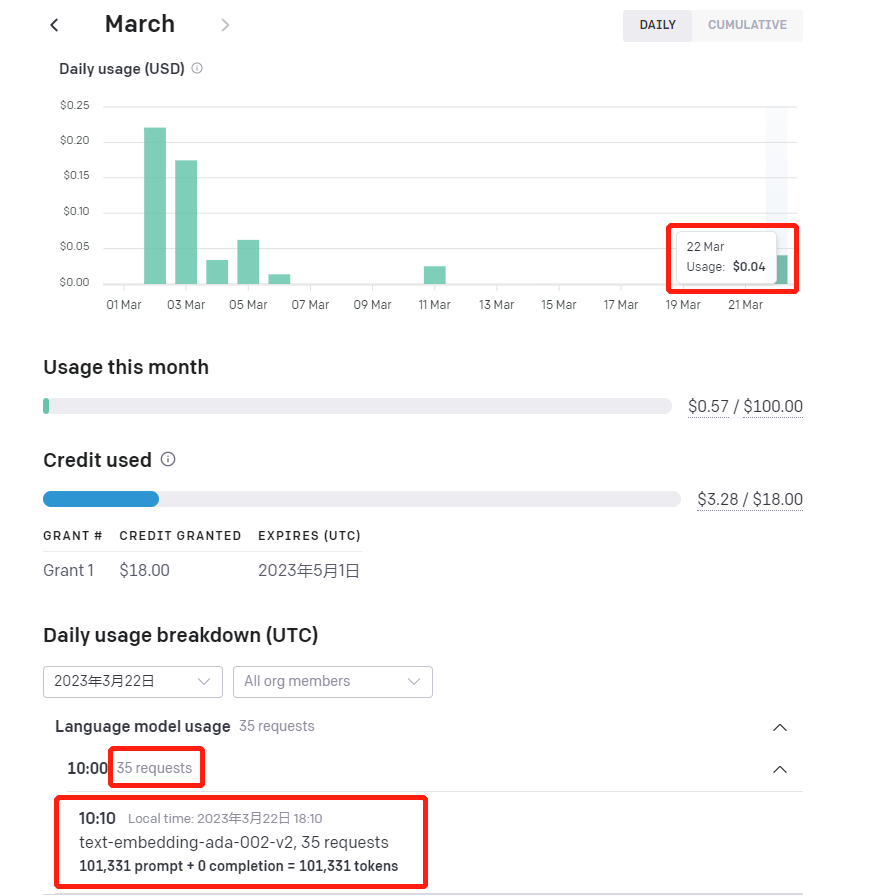

In [25]:
from IPython.display import Image
Image(filename="ada_priced.png")

In [6]:
len(chunks)

57

In [7]:
tokens = tokenizer.encode(chunks[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (1874 > 1024). Running this sequence through the model will result in indexing errors


In [8]:
len(tokens)

1874

**<font size="4">将切分后的内容通过API调用ada-002模型进行embedding处理，并将结果写出到.json文件中</font>**

In [12]:
import openai
import json
import textwrap

def open_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as infile:
        return infile.read()

openai.api_key = open_file('openaiapikey.txt')

In [ ]:
def gpt3_embedding(content, engine='text-embedding-ada-002'):  ## Ada is priced at $0.0004 / 1K tokens
    response = openai.Embedding.create(input=content,engine=engine)
    vector = response['data'][0]['embedding']  # this is a normal list
    return vector


result = list()
for chunk in chunks:
    embedding = gpt3_embedding(chunk.encode(encoding='ASCII',errors='ignore').decode())
    info = {'content': chunk, 'vector': embedding}
    print(info, '\n\n\n')
    result.append(info)
with open('embedded chunks.json', 'w') as outfile:
    json.dump(result, outfile, indent=2)

**<font size="4">定义function，输入chunk要求gpt3.5模型将chunk内容进行缩写，然后将缩写内容和下一段chunk一并输入模型，再缩写，不断循环至全部57条chunk全部处理完毕。最后一次输出的缩写内容即为对全文的缩写概括。</font>**

In [13]:
import re
import os
from time import time, sleep
import openai

def gpt35_chat_condense(chunk, previous_condensed="", target_length=900, engine='gpt-3.5-turbo', temp=0.5, top_p=1.0):
    max_retry = 5
    retry = 0

    system_prompt = f"Condense the following text into fewer words, the reponse shall never exceed a length of {target_length} tokens:\n\n{chunk}\n\n"

    if previous_condensed:
        user_prompt = f"The previously condensed information is:\n\n{previous_condensed}\n\nCombine and condense the information from the new text and the previously condensed information."
    else:
        user_prompt = ""

    conversation = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]

    while True:
        try:
            response = openai.ChatCompletion.create(
                model=engine,
                messages=conversation,
                temperature=temp,
                top_p=top_p,
            )
            text = response['choices'][0]['message']['content'].strip()
            text = re.sub('[\r\n]+', '\n', text)
            text = re.sub('[\t ]+', ' ', text)

            return text

        except Exception as oops:
            retry += 1
            if retry >= max_retry:
                return "GPT3 error: %s" % oops
            print('Error communicating with OpenAI:', oops)
            sleep(5)

# CALL
condensed_text = ""

log_file = 'condense_log.txt'

from transformers import GPT2Tokenizer

# Initialize the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

with open(log_file, 'w', encoding='utf-8') as f:
    pass  # Clear the log file before writing new content

# Calculate the total number of tokens for all chunks
total_tokens = sum([len(tokenizer.encode(chunk)) for chunk in chunks])

# Calculate the cost estimate
cost_per_token = 0.002 / 1000  # USD 0.002 per 1000 tokens
total_cost = total_tokens * cost_per_token

print(f"Total tokens: {total_tokens}")
print(f"Estimated cost: ${total_cost:.4f}")

# Ask the user if they want to proceed
user_input = input("Do you want to proceed? (yes/no): ").lower()

if user_input == 'yes':
    for idx, chunk in enumerate(chunks):
        condensed_text = gpt35_chat_condense(chunk, condensed_text, target_length=900)

        with open(log_file, 'a', encoding='utf-8') as f:
            f.write(f"Round {idx + 1}:\n\n")
            f.write("Input:\n")
            f.write(chunk)
            f.write("\n-------\n")
            f.write("Output:\n")
            f.write(condensed_text)

            if idx < len(chunks) - 1:
                f.write("\n\n======\n\n")

        print(f"Progress: Completed {idx + 1}/{len(chunks)}")
else:
    print("Operation cancelled.")

Token indices sequence length is longer than the specified maximum sequence length for this model (1874 > 1024). Running this sequence through the model will result in indexing errors


Total tokens: 103574
Estimated cost: $0.2071
Do you want to proceed? (yes/no): yes
Progress: Completed 1/57
Progress: Completed 2/57
Error communicating with OpenAI: Error communicating with OpenAI: ('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None))
Progress: Completed 3/57
Progress: Completed 4/57
Progress: Completed 5/57
Error communicating with OpenAI: Error communicating with OpenAI: ('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None))
Error communicating with OpenAI: Error communicating with OpenAI: ('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None))
Progress: Completed 6/57
Progress: Completed 7/57
Progress: Completed 8/57
Progress: Completed 9/57
Progress: Completed 10/57
Progress: Completed 11/57
Progress: Completed 12/57
Progress: Completed 13/57
Progress: Completed 14/57
Progress: Completed 15/57
Progress: Completed 16/57
Progress: Completed 17/57
Progres

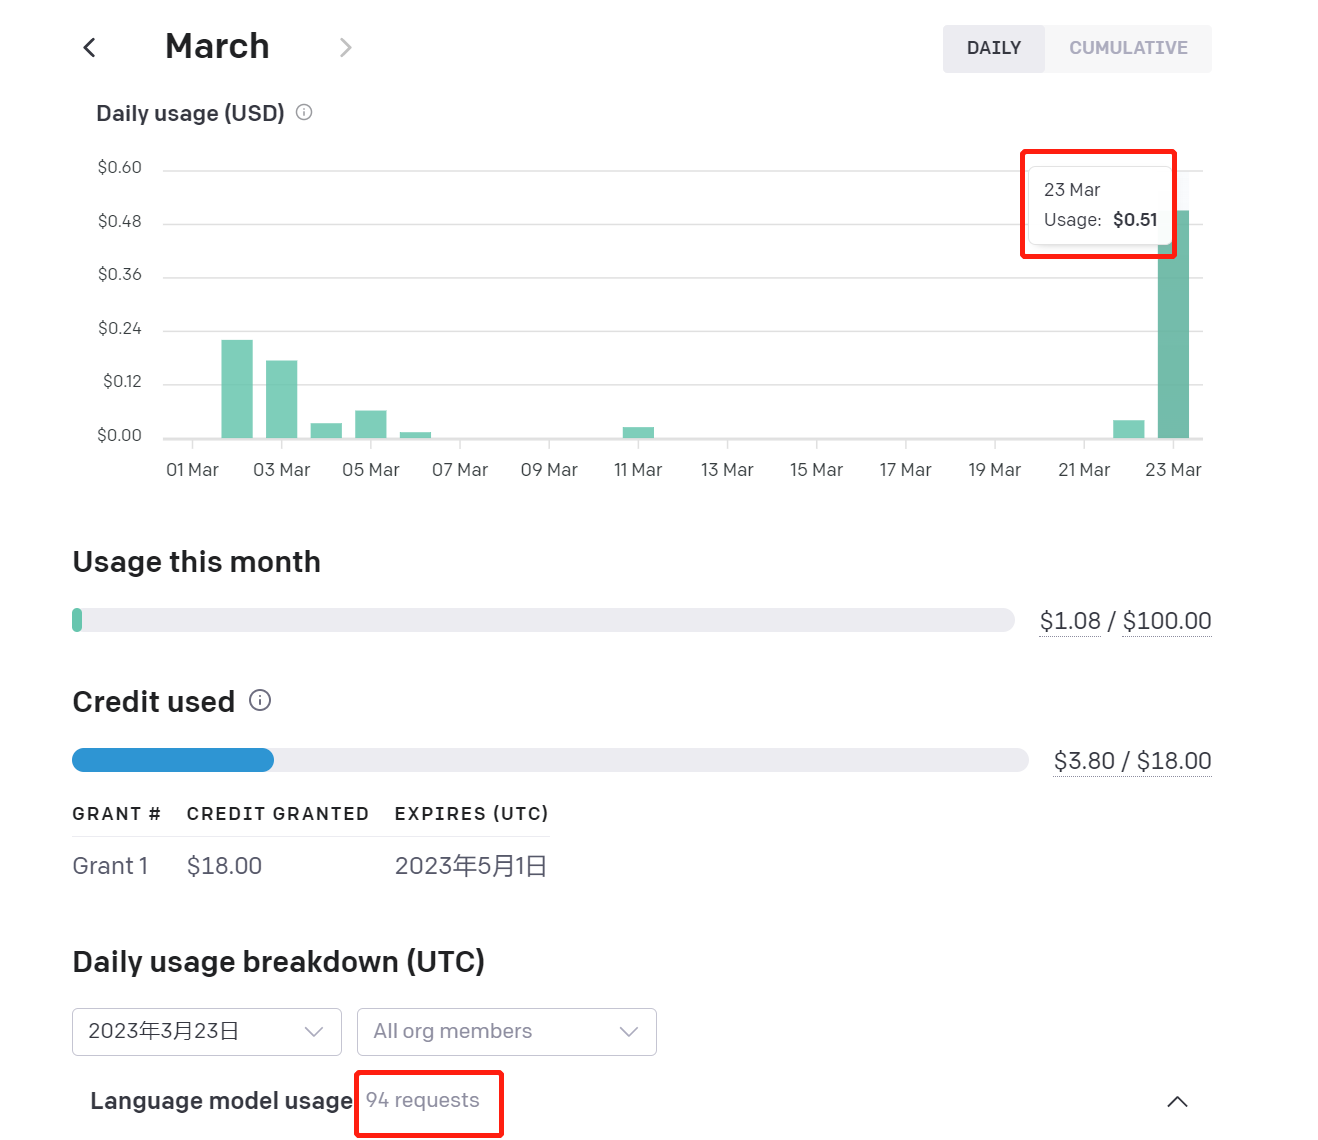

In [40]:
from IPython.display import Image
Image(filename="turbo_priced.png")